# Vision Transformer (ViT) for Image Classification

## Steps:

1. Loading & preprocess & splitting the dataset into training, validation, and testing sets.

    This applies resizing, normalization, and filtering out invalid images for the dataset. Class labels are converted into one hot encoded vectors for each image. The dataset is split into train, validation, and test sets with a 70:15:15. DataLoaders are created for each split to efficiently migrate the data into a model during training and evaluation.

In [14]:
import torch
import torch.nn.functional as torch_function
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, TensorDataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score

def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except Exception:
        print(f"Skipping an invalid image file: {path}")
        return False

dataset_path = "PetImages"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root = dataset_path, transform = transform, is_valid_file = is_valid_image)
num_classes = len(dataset.classes)
class_names = dataset.classes


def create_one_hot_dataset(original_dataset, num_classes):
    images = []
    one_hot_labels = []

    for img, label in original_dataset:
        images.append(img)
        label_long = torch.tensor(label, dtype = torch.long)
        one_hot = torch_function.one_hot(label_long, num_classes = num_classes)
        one_hot_labels.append(one_hot)

    images_tensor = torch.stack(images)
    labels_tensor = torch.stack(one_hot_labels)

    return TensorDataset(images_tensor, labels_tensor)

dataset = create_one_hot_dataset(dataset, num_classes = num_classes)

all_indices = list(range(len(dataset)))
train_indices, temp_indices = train_test_split(all_indices, test_size = 0.30, random_state = 42)
val_indices, test_indices = train_test_split(temp_indices, test_size = 0.50, random_state = 42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers = 4)

print("-----------------------------------------------------------------")
print(f"Total valid images: {len(dataset)}")
print("Total examples in dataset:", len(dataset))
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Skipping an invalid image file: PetImages/Cat/666.jpg
Skipping an invalid image file: PetImages/Cat/Thumbs.db
Skipping an invalid image file: PetImages/Dog/11702.jpg


/opt/homebrew/anaconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping an invalid image file: PetImages/Dog/Thumbs.db
-----------------------------------------------------------------
Total valid images: 24998
Total examples in dataset: 24998
Training set size: 17498
Validation set size: 3750
Test set size: 3750


2. Implementing a class for ViT model & Training + Test

    I implement a Vision Transformer model for image classification using PyTorch. The input image is divided into patches, and each patch is embedded into a vector using a convolutional layer. A class token is appended. Positional embeddings are added to preserve the patch information. The sequence is delivered through multiple Transformer encoder layers to get long range dependencies. The class token output is passed through an MLP head to predict class probabilities.

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size = 224, patch_size = 16, num_classes = 2, embedding_dimension = 256, depth = 6, num_heads = 8, dropout = 0.3):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0
        
        self.num_patches = (image_size // patch_size) ** 2
        self.embedding_dimension = embedding_dimension
        self.patch_embed = nn.Conv2d(in_channels = 3, out_channels = embedding_dimension, kernel_size = patch_size, stride = patch_size)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embedding_dimension))
        self.position_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, embedding_dimension))
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dimension, nhead = num_heads, dropout = dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers = depth)

        self.mlp_head = nn.Sequential(nn.LayerNorm(embedding_dimension), nn.Linear(embedding_dimension, num_classes))
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.position_embedding, std = 0.02)
        nn.init.trunc_normal_(self.class_token, std = 0.02)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std = 0.02)

                if m.bias is not None:
                    nn.init.zeros_(m.bias)

            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity = 'relu')

                if m.bias is not None:
                    nn.init.zeros_(m.bias)

            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        class_tokens = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((class_tokens, x), dim = 1)
        x = x + self.position_embedding
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        class_output = x[:, 0]

        logits = self.mlp_head(class_output)
        
        return logits

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = VisionTransformer(image_size = 224, patch_size = 16, num_classes = 2, embedding_dimension = 256, depth = 5, num_heads = 8, dropout = 0.3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 12

train_loss_list = []
train_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, one_hot_labels in train_loader:
        labels = one_hot_labels.argmax(dim = 1)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    average_train_loss = train_loss / total
    train_accuracy = correct / total
    train_loss_list.append(average_train_loss)
    train_accuracy_list.append(train_accuracy)

    model.eval()
    validation_loss = 0.0
    correct_validation = 0
    total_val = 0

    with torch.no_grad():
        for images, one_hot_labels in val_loader:
            labels = one_hot_labels.argmax(dim = 1)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, dim = 1)
            total_val += labels.size(0)
            correct_validation += (predicted == labels).sum().item()

    average_validation_loss = validation_loss / total_val
    validation_accuracy = correct_validation / total_val
    validation_loss_list.append(average_validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print(f"Epoch [{epoch + 1} of {num_epochs}] | Train Loss: {average_train_loss:.3f} | Train Accuracy: {train_accuracy:.3f} | Validation Loss: {average_validation_loss:.3f} | Validation Accuracy: {validation_accuracy:.3f}")

model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
predictions = []

with torch.no_grad():
    for images, one_hot_labels in test_loader:
        labels = one_hot_labels.argmax(dim = 1)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

avg_test_loss = test_loss / total
test_accuracy = correct / total
f1 = f1_score(all_labels, predictions, average = 'binary')
recall = recall_score(all_labels, predictions, average = 'binary')
precision = precision_score(all_labels, predictions, average = 'binary')

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1 of 12] | Train Loss: 0.685 | Train Accuracy: 0.549 | Validation Loss: 0.658 | Validation Accuracy: 0.581
Epoch [2 of 12] | Train Loss: 0.649 | Train Accuracy: 0.598 | Validation Loss: 0.648 | Validation Accuracy: 0.617
Epoch [3 of 12] | Train Loss: 0.636 | Train Accuracy: 0.621 | Validation Loss: 0.622 | Validation Accuracy: 0.640
Epoch [4 of 12] | Train Loss: 0.630 | Train Accuracy: 0.627 | Validation Loss: 0.623 | Validation Accuracy: 0.647
Epoch [5 of 12] | Train Loss: 0.618 | Train Accuracy: 0.644 | Validation Loss: 0.616 | Validation Accuracy: 0.653
Epoch [6 of 12] | Train Loss: 0.601 | Train Accuracy: 0.664 | Validation Loss: 0.595 | Validation Accuracy: 0.674
Epoch [7 of 12] | Train Loss: 0.591 | Train Accuracy: 0.674 | Validation Loss: 0.586 | Validation Accuracy: 0.682
Epoch [8 of 12] | Train Loss: 0.583 | Train Accuracy: 0.685 | Validation Loss: 0.592 | Validation Accuracy: 0.681
Epoch [9 of 12] | Train Loss: 0.575 | Train Accuracy: 0.693 | Validation Loss: 0.568 | V

3. Performance for the ViT model

- Loss: The training loss steadily decreased from about 0.68 to around 0.54. This shows consistent improvement on the training. The validation loss generally followed a similar trend. But it tend to represent some fluctuations around epochs 5 or 8. The model converges.

- Accuracy: Training accuracy and validation accuracy both increase continuously from 50% to 71%. The upward trend indicates consistent improvements in the model’s performance. Both curves converge near 70% by the final epoch, . It turns out that the model can learn effectively without overfitting.

- Other Performance metrics: The model achieves a test accuracy of about 70% and a loss of 0.58. The F1 score is 0.740 with a well balanced approach to precision and recall. The high recall of 0.835 shows it detects most positive cases. The precision of 0.66 may not be best for classifying negatives correctly.


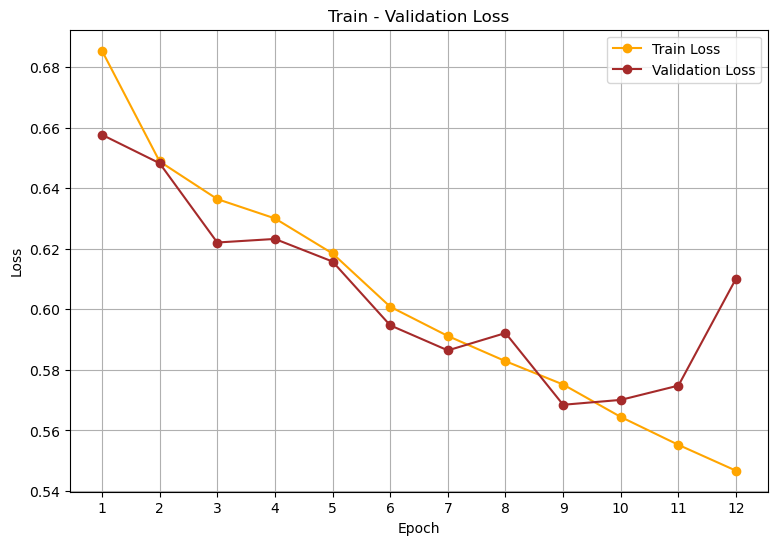

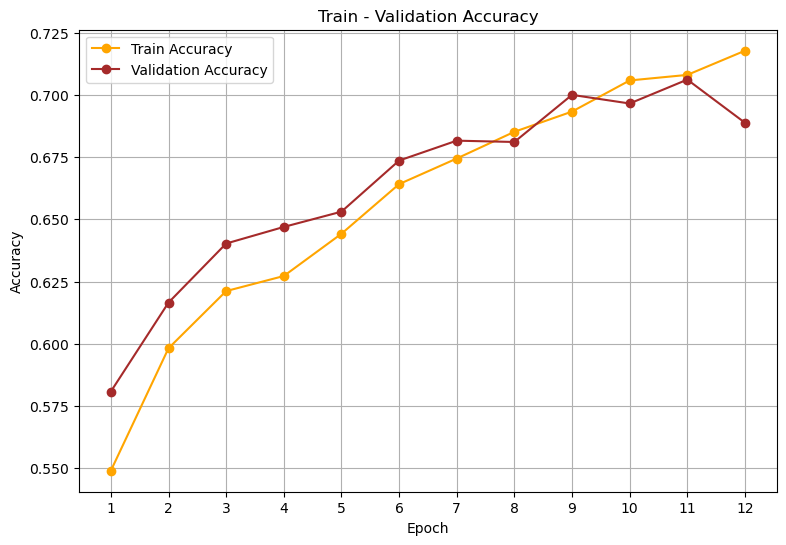

------------------------------------------------------------------------
Test Loss: 0.589
Test Accuracy: 0.701
F1 Score: 0.740
Recall: 0.835
Precision: 0.664


In [ ]:
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, train_loss_list, marker = "o", label = "Train Loss", color = "orange")
plt.plot(epochs, validation_loss_list, marker = "o", label = "Validation Loss", color = "brown")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train - Validation Loss")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (9, 6))
plt.plot(epochs, train_accuracy_list, marker = "o", label = "Train Accuracy", color = "orange")
plt.plot(epochs, validation_accuracy_list, marker = "o", label = "Validation Accuracy", color = "brown")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train - Validation Accuracy")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

print("------------------------------------------------------------------------")

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")


4. Application to take an image as input and predicts whether it's a cat or a dog.

    I define a function to select randomly an image from the test dataset and to process it for classification. It undo normalization about the image and passes it through the model to obtain a predicted class. The function extracts both the predicted and true labels. I can see the image with a title indicating these labels.

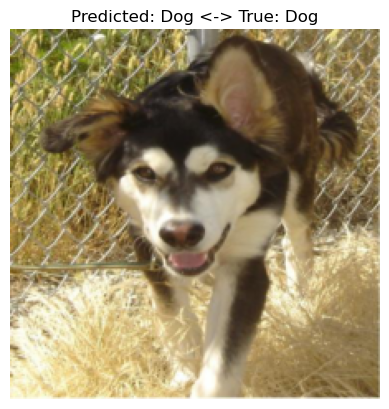

In [15]:
def image_classification_test_application(test_dataset, model, device, class_names):
    random_index = random.randint(0, len(test_dataset) - 1)
    image_tensor, one_hot_label = test_dataset[random_index]
    true_label = one_hot_label.argmax(dim = 0)
    input_tensor = image_tensor.unsqueeze(0).to(device)
    
    model.eval()

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, dim = 1)

    predicted_class = class_names[predicted.item()]
    true_class = class_names[true_label.item()]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    plt.imshow(image_np)
    plt.title(f"Predicted: {predicted_class} <-> True: {true_class}")
    plt.axis("off")
    plt.show()

image_classification_test_application(test_dataset, model, device, class_names)


5. Shared UBbox Video Link: https://buffalo.box.com/s/jp460teh503lbzbs7hzc9aszng7qfbok

6. References

- Dataset URL: https://huggingface.co/datasets/SetFit/enron_spam
https://www.microsoft.com/en-us/download/details.aspx?id=54765
- An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (https://arxiv.org/abs/2010.11929)
- Pytorch Vision Transformer Tutorial (https://pytorch.org/vision/stable/models.html#transformer-based)
- HuggingFace ViT (https://huggingface.co/docs/transformers/model_doc/vit)
- Visualized Transformer (https://jalammar.github.io/illustrated-transformer/)
- MIT Han Lab's Vision Transfomer (https://www.youtube.com/watch?v=QQY24LLww1A&ab_channel=MITHANLab)